In [1]:
import scarches as sca
import scanpy as sc
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.sparse
import numpy as np
import pandas as pd
import os
import sys
import importlib

Using TensorFlow backend.


In [2]:
sys.path.insert(0, "../lib")

In [3]:
import sc_utils

In [4]:
pd.set_option('display.max_rows', 1000)

In [5]:
mpl.rcParams["figure.figsize"] = (14, 12)

In [6]:
latent = sc.read_h5ad("../data/03ipf_projection/01latent2.h5ad")

In [7]:
combined = sc.read_h5ad("../data/03ipf_projection/01combined.h5ad")

In [8]:
latent.obs.population.value_counts()

Immune-TX         76534
Immune            61393
Epithelial        37325
Epithelial-TX     32416
Stromal-TX        31032
Endothelial-TX    15431
Endothelial       10446
Mesenchymal        5232
Name: population, dtype: int64

In [9]:
latent = latent[latent.obs.population.isin(["Mesenchymal", "Stromal-TX"]), ]
stro = combined[combined.obs.population.isin(["Mesenchymal", "Stromal-TX"]), ]

In [10]:
latent.shape

(36264, 10)

In [11]:
stro.shape

(36264, 19202)

In [12]:
stro.obs.Diagnosis = stro.obs.Diagnosis.cat.reorder_categories(
    ["Control (H.)", "Control (B.)", "COVID-19", "IPF", "Other PF"]
)

Trying to set attribute `.obs` of view, copying.


In [13]:
sc.tl.leiden(latent, resolution=0.2)

Trying to set attribute `.obs` of view, copying.


In [14]:
stro.obs["leiden"] = latent.obs.leiden

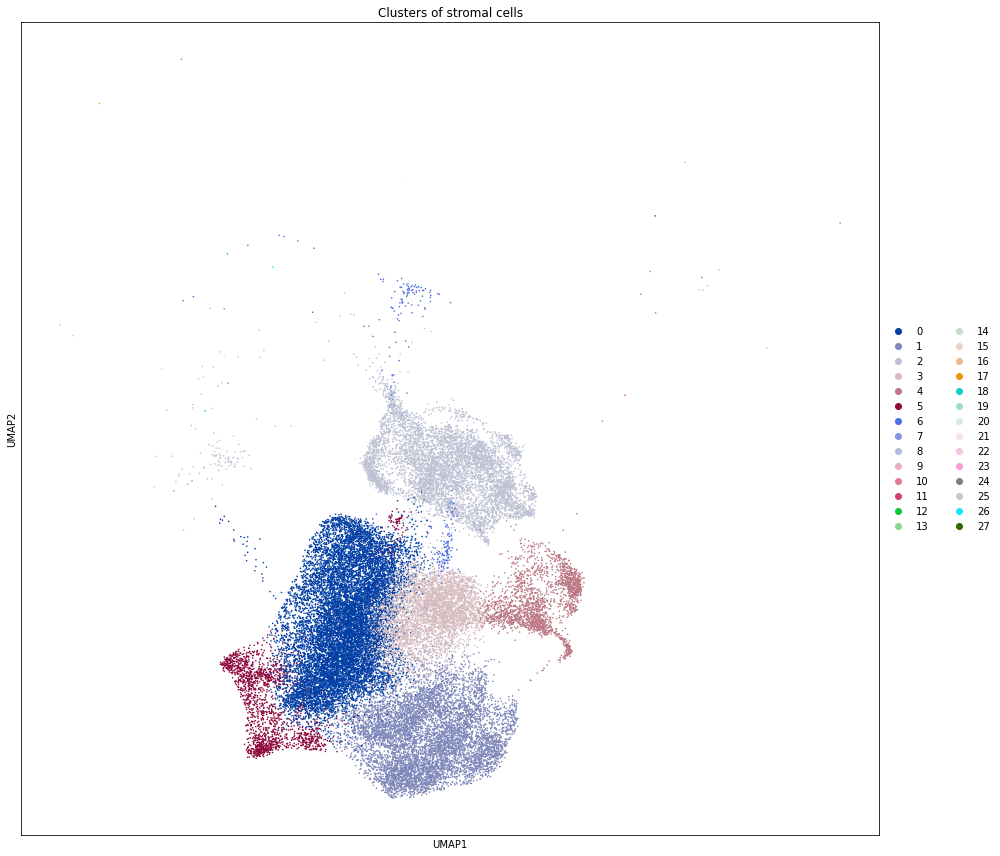

In [15]:
ax = sc.pl.umap(
    stro, 
    color="leiden",
    size=10, 
    title="Clusters of stromal cells",
    legend_fontoutline=3,
    legend_fontweight="normal",
    show=False
)
ax.figure.tight_layout()

In [16]:
leiden_size = stro.obs.leiden.value_counts()

In [17]:
leiden_size

0     13497
1      7701
2      6656
3      4041
4      2182
5      1909
6       253
7         3
8         2
9         2
26        1
10        1
11        1
12        1
27        1
14        1
15        1
16        1
17        1
18        1
19        1
20        1
21        1
22        1
23        1
24        1
25        1
13        1
Name: leiden, dtype: int64

In [18]:
latent = latent[~latent.obs.leiden.isin(leiden_size.index[leiden_size <= 3]), :]
stro = stro[~stro.obs.leiden.isin(leiden_size.index[leiden_size <= 3]), :]

In [19]:
sc.tl.leiden(latent, resolution=0.4)

Trying to set attribute `.obs` of view, copying.


In [20]:
latent.obs.leiden.value_counts()

0     8141
1     6146
2     5978
3     4603
4     4401
5     2222
6     2167
7     1537
8      743
9      246
10      53
11       2
Name: leiden, dtype: int64

In [21]:
stro.obs["leiden"] = latent.obs.leiden

Trying to set attribute `.obs` of view, copying.


In [22]:
latent = latent[~latent.obs.leiden.isin(["9", "10", "11"]), :]

In [23]:
stro = stro[~stro.obs.leiden.isin(["9", "10", "11"]), :]

Trying to set attribute `.uns` of view, copying.


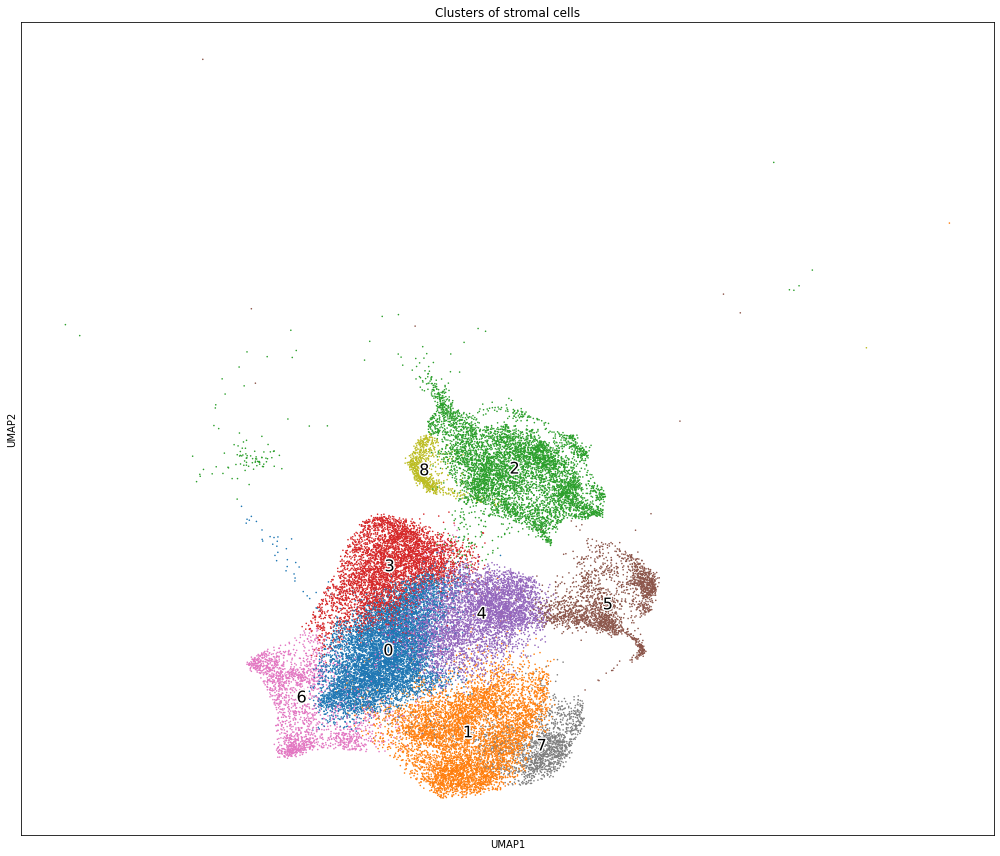

In [24]:
ax = sc.pl.umap(
    stro, 
    color="leiden",
    size=10, 
    title="Clusters of stromal cells",
    legend_loc="on data",
    legend_fontsize=16,
    legend_fontoutline=3,
    legend_fontweight="normal",
    show=False
)
ax.figure.tight_layout()

2+8

0+3

6 as is

1+7

5 as is

4 as is (edited) 

In [25]:
stro.obs["cluster"] = stro.obs.leiden.copy()

In [26]:
stro.obs.loc[stro.obs.cluster.isin(["8"]), "cluster"] = "2"
stro.obs.loc[stro.obs.cluster.isin(["3"]), "cluster"] = "0"
stro.obs.loc[stro.obs.cluster.isin(["7"]), "cluster"] = "1"

In [27]:
stro.obs.cluster = stro.obs.cluster.astype("str")
stro.obs.cluster.replace({
    "0": "1",
    "1": "2",
    "2": "3",
}, inplace=True)
# 6>1
# 1>2
# 2>3
# 4>4
# 5>5
# 3>6
stro.obs.cluster.replace({
    "6": "1",
    "1": "2",
    "2": "3",
    "3": "6"
}, inplace=True)
stro.obs.cluster = stro.obs.cluster.astype("category")

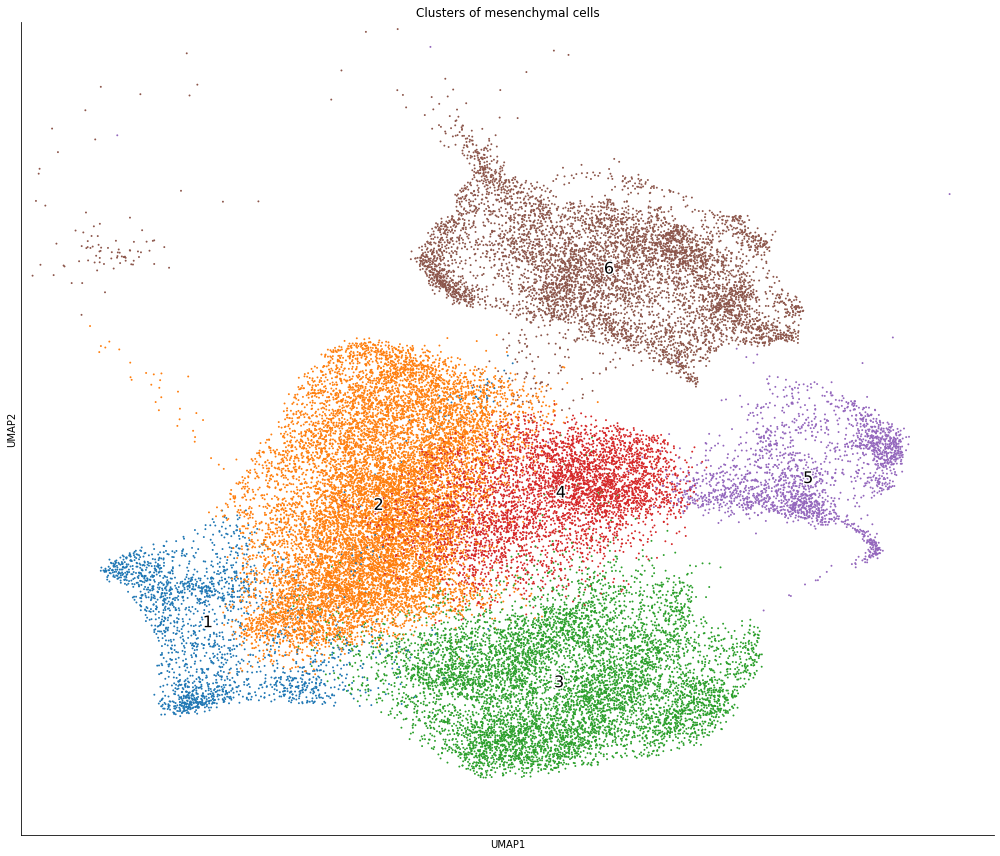

In [28]:
ax = sc.pl.umap(
    stro, 
    color="cluster",
    size=15, 
    frameon=True,
    title="Clusters of mesenchymal cells",
    legend_loc="on data",
    legend_fontsize=16,
    legend_fontoutline=3,
    legend_fontweight="normal",
    show=False
)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
# ax.xaxis.set_visible(True)
# ax.xaxis.reset_ticks()
# ax.set_axis_on()
# ax.tick_params(reset=True)
# ax.set_yticks([0, 5, 10, 15])
# ax.set_xticks([0, 5, 10, 15])
ax.set_ylim(top=5)
ax.set_xlim((-2, 11))
ax.figure.tight_layout()
ax.figure.savefig("04stro-clusters.pdf")

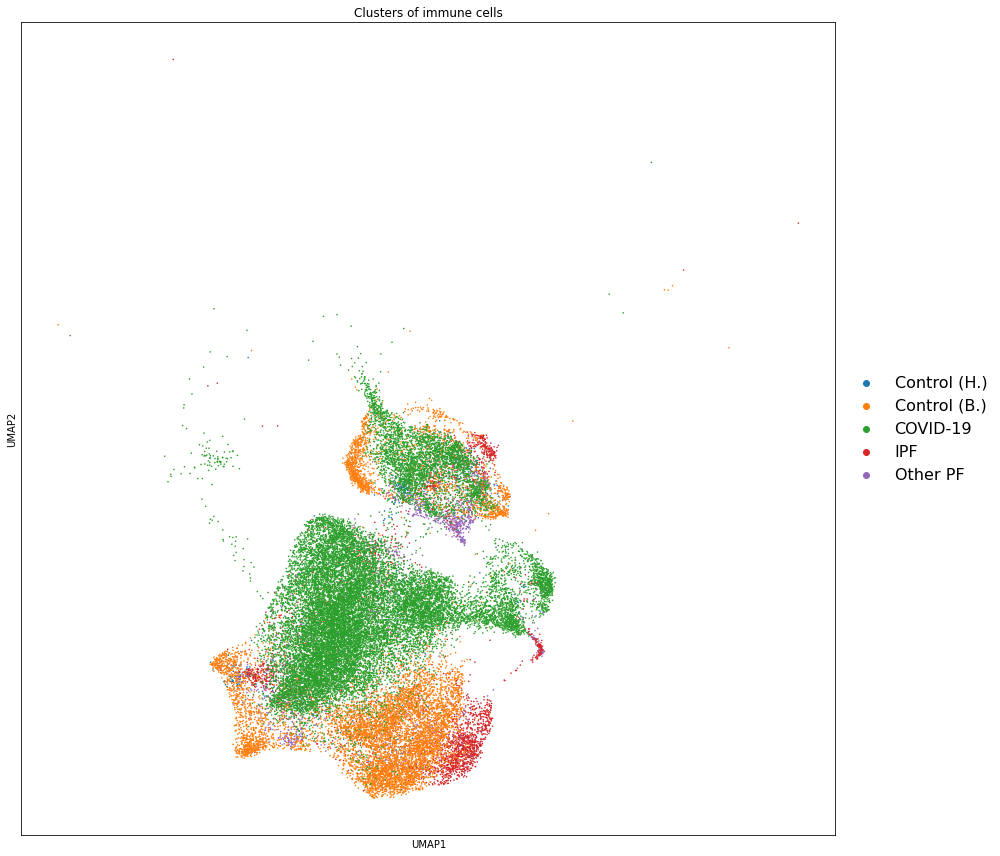

In [29]:
ax = sc.pl.umap(
    stro, 
    color="Diagnosis",
    size=10, 
    title="Clusters of immune cells",
    legend_fontsize=16,
    legend_fontoutline=3,
    legend_fontweight="normal",
    show=False
)
ax.figure.tight_layout() 

<AxesSubplot:title={'center':'Leiden by celltype'}>

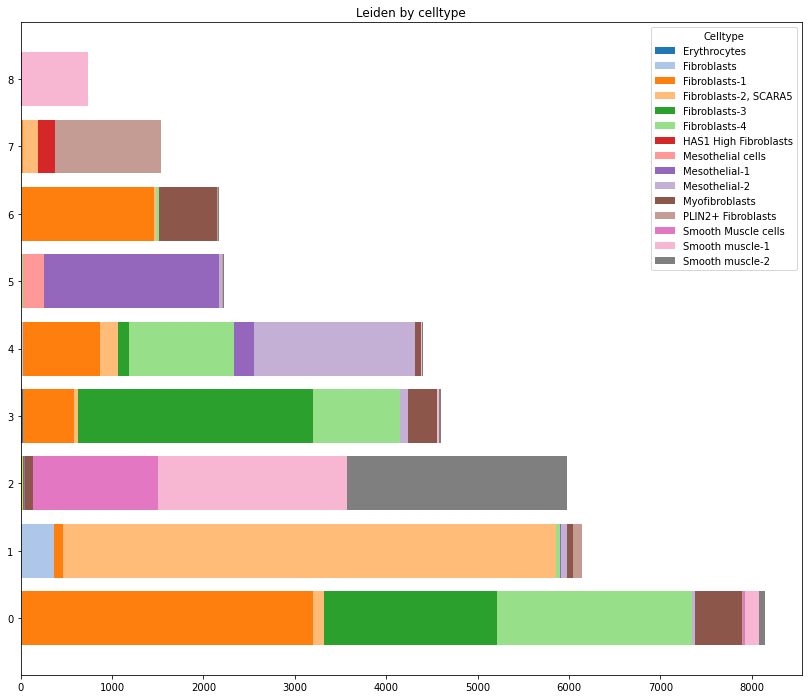

In [30]:
sc_utils.plot_composition(stro, "leiden", "celltype")

<AxesSubplot:title={'center':'Leiden by Diagnosis'}>

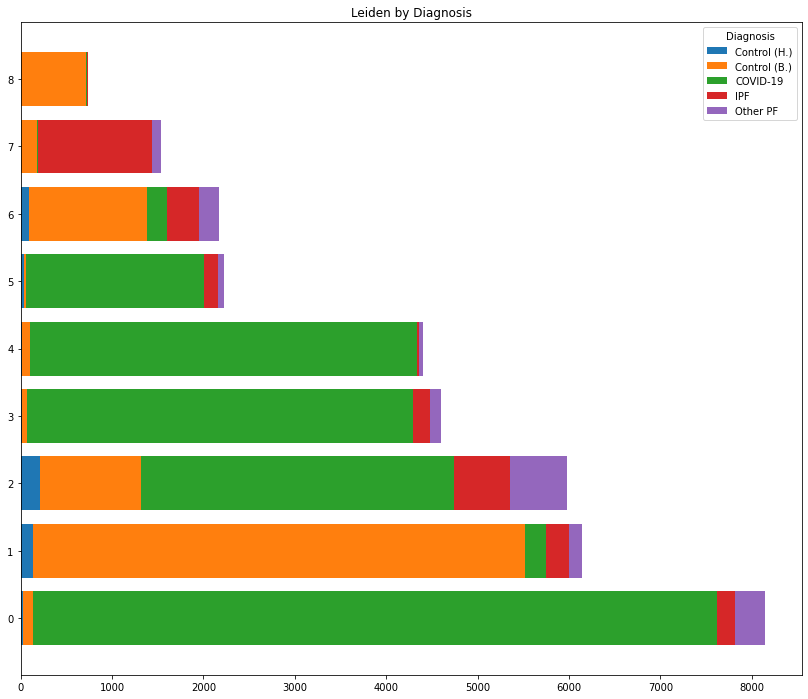

In [31]:
sc_utils.plot_composition(stro, "leiden", "Diagnosis")

In [32]:
cat_palette = list(mpl.cm.tab10.colors)
cat_palette[0], cat_palette[2] = cat_palette[2], cat_palette[0]
cat_palette[2], cat_palette[3] = cat_palette[3], cat_palette[2]

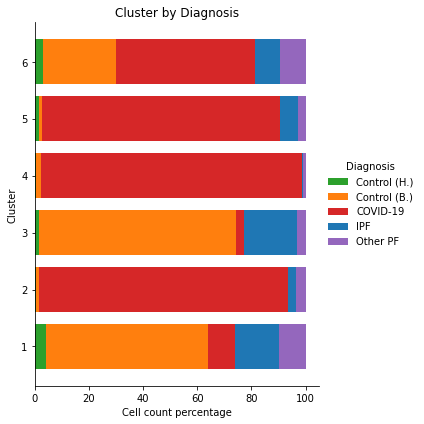

In [33]:
ax = sc_utils.plot_composition(stro, "cluster", "Diagnosis", relative=True, palette=cat_palette)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.figure.set_size_inches((6, 6))
ax.set_ylabel("Cluster")
ax.set_xlabel("Cell count percentage")
h, l = ax.get_legend_handles_labels()
ax.legend(h, l, loc="center left", bbox_to_anchor=(1, 0.5), frameon=False, title="Diagnosis")
ax.figure.tight_layout()
ax.figure.savefig("04stro-composition-rel.pdf")

In [34]:
stro.raw = stro

In [28]:
sc.tl.rank_genes_groups(stro, "leiden", method="wilcoxon", n_genes=100)
markers = sc_utils.get_markers(stro, "leiden")

In [29]:
markers.cluster = markers.cluster.astype(int)

In [30]:
markers.sort_values(
    "avg_logFC", 
    ascending=False
).groupby("cluster").head(20).sort_values(["cluster", "avg_logFC"], ascending=[True, False])

,p_val,avg_logFC,pct.1,pct.2,p_val_adj,cluster,gene
0,0.000000e+00,3.340677,0.996069,0.687916,0.000000e+00,0,LUM
6,0.000000e+00,3.046630,0.825329,0.163291,0.000000e+00,0,XIST
2,0.000000e+00,2.968792,0.916104,0.406735,0.000000e+00,0,MDK
11,0.000000e+00,2.873785,0.928633,0.501493,0.000000e+00,0,APOE
10,0.000000e+00,2.795566,0.900504,0.377667,0.000000e+00,0,CTHRC1
7,0.000000e+00,2.744657,0.923719,0.554736,0.000000e+00,0,C11orf96
12,0.000000e+00,2.643857,0.760226,0.257366,0.000000e+00,0,BASP1
16,0.000000e+00,2.569560,0.942390,0.487571,0.000000e+00,0,PTGDS
21,0.000000e+00,2.502351,0.990910,0.835234,0.000000e+00,0,COL3A1
1,0.000000e+00,2.403946,0.991647,0.712271,0.000000e+00,0,MMP2


In [31]:
stro.write_h5ad("../data/03ipf_projection/04stro.h5ad")

In [32]:
markers.to_csv("../data/03ipf_projection/04stro-markers.csv")

## Genes heatmap

In [35]:
# heatmap group
stro.obs["hm_group"] = stro.obs.Diagnosis.copy()
stro.obs.hm_group = stro.obs.hm_group.astype("str")
stro.obs.loc[stro.obs.Sample_Source == "NU", "hm_group"] = stro.obs.Sample_Name.loc[stro.obs.Sample_Source == "NU"]
stro.obs.hm_group = stro.obs.hm_group.astype("category")
stro.obs.hm_group = stro.obs.hm_group.cat.reorder_categories([
    "Control (H.)", "Donor 1", "Donor 2",
    "Other PF", "IPF", "Case 1", "PMB 1", "PMB 2"
])
stro.obs.hm_group.value_counts()

Case 1          10112
PMB 1            9385
Donor 1          5138
Donor 2          3795
IPF              3011
PMB 2            2294
Other PF         1651
Control (H.)      552
Name: hm_group, dtype: int64

In [36]:
stro.obs["heatmap"] = stro.obs.cluster.astype(str) + "," + stro.obs.hm_group.astype(str)

In [37]:
genes_of_i = """FGFR4
PCOLCE2
FBLN2
HAS1
PLIN2
DCN
LUM
MMP2
LXN
POSTN
UPK3B
MSLN
COL1A1
PDGFRA
PDGFRB
ACTA2
MYH11""".split("\n")

In [38]:
markers_expr = []
clusters = list(stro.obs.heatmap.astype(str).unique())
clusters.sort(key=lambda x: (x.split(",")[0], stro.obs.hm_group.cat.categories.get_loc(x.split(",")[1])))
for g in clusters:
    mean_exp = stro.raw.X[(stro.obs.heatmap == g).values, :][:, stro.var_names.isin(genes_of_i)].mean(axis=0).A.reshape(-1)
    markers_expr.append(mean_exp)

In [39]:
markers_expr = pd.DataFrame(markers_expr, columns=stro.var_names[stro.var_names.isin(genes_of_i)], index=clusters)

In [40]:
markers_expr = (markers_expr - markers_expr.min()) / markers_expr.max()

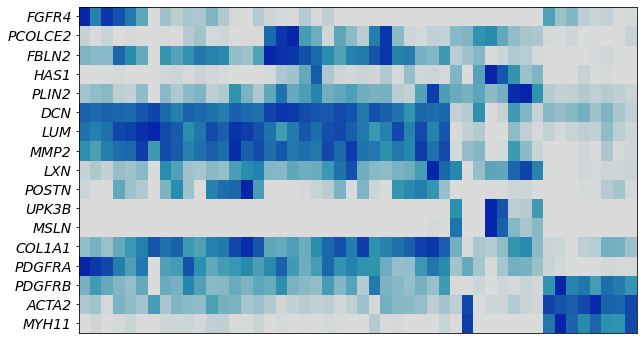

In [41]:
fig, ax = plt.subplots(
    figsize=(10, 6)
)
ax.pcolormesh(markers_expr.loc[:, reversed(genes_of_i)].T.to_numpy(), cmap=sc_utils.expr_colormap())
ax.set_yticks(pd.Series(range(len(genes_of_i))) + 0.5)
ax.set_yticklabels(
    reversed(genes_of_i),
    fontstyle="italic",
    fontsize=14
)
ax.tick_params(bottom=False, labelbottom=False)

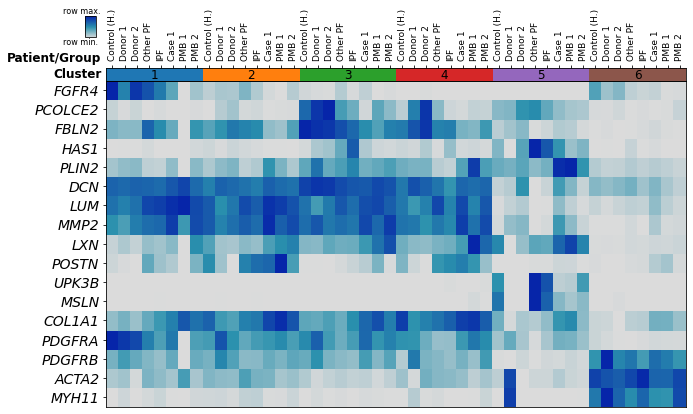

In [42]:
ax0bbox = ax.get_position()
labs = fig.add_axes((ax0bbox.x0, ax0bbox.y1, ax0bbox.width, 0.03), sharex=ax)
labs.tick_params(left=False, labelleft=False, bottom=False, labelbottom=False, top=True, labeltop=True)
clusters = pd.Series(markers_expr.index.str.split(",")).apply(lambda x: x[0]).value_counts().sort_index()
pats = pd.Series(markers_expr.index.str.split(",")).apply(lambda x: x[1])
s = 0
for i, n in enumerate(clusters.index):
    w = clusters[n]
    labs.add_patch(mpl.patches.Rectangle(
        (s, 0), 
        w, 
        1, 
        facecolor=mpl.cm.tab10(i)
    ))
    labs.annotate(
        n, 
        (w / 2 + s, 0.45),
        ha="center",
        va="center",
        color="black",
        fontsize=12
    )
    s += w
# labs.tick_params(pad=20)
labs.set_xticks(pd.Series(range(pats.size)) + 0.5)
labs.set_xticklabels(pats, fontsize=9, rotation=90, va="bottom")
labs.annotate("Patient/Group", (-0.4, 1.5), annotation_clip=False, ha="right", fontweight="bold", fontsize=12)
labs.annotate("Cluster", (-0.4, 0.2), annotation_clip=False, ha="right", fontweight="bold", fontsize=12)

cax = fig.add_axes((0.085, 0.97, 0.015, 0.05))
cax = fig.colorbar(
    mpl.cm.ScalarMappable(norm=None, cmap=sc_utils.expr_colormap()),
    cax=cax,
    ticks=[]
)
cax.ax.annotate("row min.", (-2, 0), va="top", annotation_clip=False, fontsize=8)
cax.ax.annotate("row max.", (-2, 1), va="bottom", annotation_clip=False, fontsize=8)

# available_height = ax.get_position().x0 + 0.02
# move = 0
for i, ax in enumerate(fig.axes):
    p = ax.get_position()
    if i == 2:
        p.x0 += 0.04
        p.x1 += 0.04
        p.y0 -= 0.09
        p.y1 -= 0.09
    else:
        p.x0 += 0.03
        p.x1 += 0.06
        p.y0 -= 0.1
        p.y1 -= 0.1
    ax.set_position(p)

fig.savefig("04stro-markers.pdf")
fig

In [45]:
sc.tl.rank_genes_groups(stro, "cluster", method="wilcoxon", n_genes=100)
markers = sc_utils.get_markers(stro, "cluster")

... storing 'heatmap' as categorical


In [46]:
stro.obs.leiden = stro.obs.cluster.copy()
stro.obs.drop(["heatmap", "cluster", "hm_group"], axis=1, inplace=True)

In [47]:
stro.write_h5ad("../data/03ipf_projection/04stro.h5ad")

In [48]:
markers.to_csv("../data/03ipf_projection/04stro-markers.csv")

## Find DEGs between COVID-19 and IPF

In [49]:
for c in stro.obs.leiden.cat.categories:
    subset = stro[stro.obs.leiden == c, :]
    subset = subset[subset.obs.Diagnosis.isin(["COVID-19", "IPF"]), :]
    if (subset.obs.Diagnosis.value_counts() > 100).sum() == 2:
        print(f"Computing DEGs for cluster {c}")
        sc.tl.rank_genes_groups(subset, "Diagnosis", method="wilcoxon", n_genes=0)
        degs = sc_utils.get_markers(subset, "Diagnosis")
        degs.loc[degs["pct.2"] > 0.05, :].sort_values(
            "avg_logFC", 
            ascending=False
        ).groupby("cluster").apply(lambda x: x.sort_values(
            ["cluster", "avg_logFC"], 
            ascending=[True, False]
        )).reset_index(drop=True).to_csv(f"04stro-c{c}-degs.csv")

Trying to set attribute `.uns` of view, copying.


Computing DEGs for cluster 1


Trying to set attribute `.uns` of view, copying.


Computing DEGs for cluster 2


Trying to set attribute `.uns` of view, copying.


Computing DEGs for cluster 3


Trying to set attribute `.uns` of view, copying.


Computing DEGs for cluster 5


Trying to set attribute `.uns` of view, copying.


Computing DEGs for cluster 6
